# Assignment 2

**Assignment 2: Sampling**

**Goal**: ​​Get familiar with sampling methods by implementing these methods and applying them to a given probability distribution.

In this assignment we are going to learn about sampling methods. The goal is to implement *Metropolis-Hastings** (MH) algorithm and **Simulated Annealing** (SA) algorithm and analyze their behavior. Importantly, we aim at noticing differences between these two methods.

Here, we are interested in ​**sampling**​ from a mixture of two Gaussians, namely:

$$
p(\mathbf{x}) = 0.25\cdot \mathcal{N}\left(\mu = \begin{bmatrix} 2 \\ 2 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & 0.5 \\ 0.5 & 1 \end{bmatrix} \right) + 0.75\cdot \mathcal{N}\left(\mu = \begin{bmatrix} -3 \\ -3 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}\right)
$$

In this assignemnt, you are asked to implement:
1. The Metropolis-Hastings (MH) algorithm.
2. The simulated annealing (SA) algorithm.

After implementing both methods, please run experiments and compare both methods. Please follow all instructions.

## 1. Understanding the probability distribution

Please run the code below and visualize the probability distribution. Please try to understand this distribution, what the modes are (you can do it by inspecting the plot). What are possible problems here?

If any code line is unclear to you, please read on that in numpy or matplotlib docs.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

EPS = 1.0e-7

In [2]:
# PLEASE DO NOT REMOVE!
# The definition of the probability distribution.
mv1 = multivariate_normal(mean=[2.0, 2.0], cov=[[1.0, 0.5], [0.5, 1.0]])
mv2 = multivariate_normal(mean=[-3.0, -3.0], cov=[[1.0, 0.0], [0.0, 1.0]])


def prob(x):
    return 0.25 * mv1.pdf(x) + 0.75 * mv2.pdf(x)

In [3]:
# PLEASE DO NOT REMOVE!
# Calculating the probability distribution.
def calculate_p(x1, x2):
    p_x = []
    for i in range(len(x1)):
        for j in range(len(x2)):
            p_x.append(prob(np.asarray([[x1[i], x2[j]]])))

    return np.asarray(p_x).reshape(len(x1), len(x2))

In [4]:
# PLEASE DO NOT REMOVE!
# Define coordinates
x1 = np.linspace(-10.0, 10.0, 400)
x2 = np.linspace(-10.0, 10.0, 400)

# Calculate the objective
p_x = calculate_p(x1, x2).reshape(len(x1), len(x2))

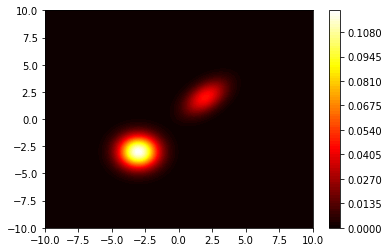

In [5]:
# PLEASE DO NOT REMOVE!
# Plot the objective
plt.contourf(x1, x2, p_x, 100, cmap="hot")
plt.colorbar()

**Question 1 (0-0.5pt):** How many modes do we have and what are they? What is the most probable point?

**Answer:**
As we can see from the graph, there are 2 peaks, which can also be called modes, diagnoally across from each other towards the middle of the graph. The lower right one is a higher peak of the twwo modes, making the location of the most probable point be at its center.

## 2. The Metropolis-Hastings algorithm

First, you are asked to implement the Metropolis-Hastings (MH) algorithm. Please take a look at the class below and fill in the missing parts.

NOTE: Please pay attention to the inputs and outputs of each function.

NOTE: To implement the MH algorithm, you need to specify the proposal distribution.

**Question 2 (0-0.5pt):** What is the proposal distribution, $q(\mathbf{x}_{new} | \mathbf{x}_{old})$, in your case?

**Answer:**
As we want to use an approximation, I decided to use a normal distriution as the proposal distribution as described below:

$q(\mathbf{x}_{new} | \mathbf{x}_{old}) = \mathcal{N}(\mathbf{x}_{new} | \mathbf{x}_{old}, \mathbf{\sigma^2})$


**Question 3 (0-0.5pt):** Is your proposal a proper proposal distribution? (That is, it must fulfill irreducibility and aperiodicity, see Andrieu et al., "An Introduction to MCMC for Machine Learning".)

**Answer:**

**Irreducibility** - the ability to visit all points = positive probability of visiting all states. A normal distribution doesn't have a negative or zero probability as for any x value, the corresponding y is positive as we negative probabilites do not exist and the 0 one is not within the definition of the normal distribution, ie. it's outside the graph or there is a gap between data.

**Aperiodicity** - the markov chain shouldn't get trapped in cycles because then it wouldn't be differentiable. We know a normal distribution doesn't have cycles, because on the x axis there are no duplicates and thus there is a unique mapping for each x.

Thus we conclude that using the normal distribution is a proper proposal distribution 

In [57]:
# =========
# GRADING:
# 0
# 0.5pt if properly implemented but badly commented
# 1.0 pt if properly implemented and clear
# =========
# Implement the Metropolis Hastings (MH) algorithm.
# It might be you use another arguments beside standard deviation (std).
# Please add them then.


class MetropolisHastings(object):
    def __init__(self, x, prob, std=0.1):
        self.prob = prob
        self.std = std
        self.x_old = x

    def proposal(self, x):
        
        #sampling from chosen proposal distribution N from current state to new state by st dev
        x_new = np.random.normal(loc=self.x_old, scale=self.std)
        return x_new

    def evaluate(self, x_new, x_old):
        
        #calulation of A wit Q crossed out from slides 
        A = self.prob(x_new)/self.prob(x_old)
        
        #returting A capped at 1
        return np.minimum(1.0, A)

    def select(self, x_new, A):
        
        #choose a new state depending on comparison with randomly chosen one
        
        #choose random u
        u = np.random.uniform(0,1)
        
        #compare against A, if A larger than random, accept new
        if A > u:
            self.x_old = x_new
        return self.x_old


    def step(self):
        # 1. Proposal
        x_prop = self.proposal(self.x_old)
        # 2. Evaluate
        A = self.evaluate(x_prop, self.x_old)
        # 3. Select
        x_new = self.select(x_prop, A)
        return x_new

In [58]:
# PLEASE DO NOT REMOVE!
# An auxiliary function for plotting.
def plot_sampling_process(ax, sampler, title):
    # Plot the objective function
    ax.contourf(x1, x2, p_x / p_x.sum(), 100, cmap="hot")

    # Init the solution
    x_samp = sampler.x_old
    # Run the optimization algorithm
    count = 0  # we calculate how many of new candidates were accepted
    for i in range(num_epochs):
        x = sampler.step()

        if (x == x_samp[-1]).all():
            pass
        else:
            count = count + 1
            x_samp = np.concatenate((x_samp, x), 0)

    ax.scatter(x_samp[:, 0], x_samp[:, 1], marker="+")
    # We add AR (Acceptance Rate) to the title.
    ax.set_title(title + " AR={:.2f}".format(count / num_epochs))

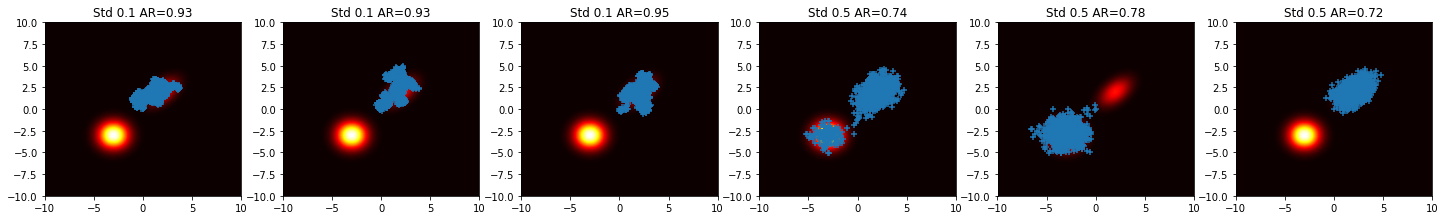

In [59]:
# PLEASE DO NOT REMOVE!
# Running the MH algorithm with different step sizes
num_epochs = 1500  # the number of epochs
stds = [0.1, 0.1, 0.1, 0.5, 0.5, 0.5]  # we repeat experiments 3 times per std
## If you add any other hyperparameters, please include them during init!
## However, please do not include them in the for-loop. It should stay for stds only.

# plotting the convergence of the MH
fig_mh, axs = plt.subplots(1, len(stds), figsize=(20, 3))
fig_mh.tight_layout()

x_init = np.asarray([[0.0, 0.0]])

for i in range(len(stds)):
    # take the std
    std = stds[i]
    # init the MH
    mh = MetropolisHastings(x=x_init, prob=prob, std=std)
    # plot the convergence
    plot_sampling_process(axs[i], sampler=mh, title="Std " + str(mh.std))

**Question 4 (0-0.5)**: Please comment on the behavior of the MH for different values of the standard deviation. Is it always possible to sample from both modes theoretically? What did you observe in practice on plots? 

**Answer**: In essence, the standard deviation determines the size of the step in the probability space, the higher the st dev, the larger the step. Thus, as can also be seen above, it is less likely to simply find the nearest clump of values and instead find the one that is further from the center (where the algorithm starts) but has more values, or find both. Of course, if the steps are too small, the convergence is slow but they can also be too large resulting in high rejection. In theory, the two modes can be far apart and have a region of low probability density and thus the algorithm would get stuck in one of them. We can see something like that in the 0.1 standard deviation version of the run above, where the algorithm found one of the modes but wasnt able to climb out of it. In 0.5 however, we see that the modes aren't far enough apart to discourge it from finding both modes. 

**Question 5 (0-0.5)**: Please comment on the acceptance ratio (AR) for std=0.1 and std=0.5. How can you explain the difference?

**Answer**: A high AR leads to a more efficient and faster sampling, as it is more likely to accept a proposed sample. But, a high AR, as can be seen above also leads to getting stuck in one mode and thus the generated samples do not represent a full distribution. On the other hand, a low AR will be slower to converge and thus may require other adjustments. As we can see above, the slow standard deviation with high AR does not model as well as the higher st dev but with lower AR, as one of our runs was able to model quite well. The main difference is the convergence is more agressive in the lefthand runs and while more messy, more liekyl to model better in the right hand low AR high ST runs. Overall its a balancing act.

## 3. The simulated annealing (SA) sampling

In the second part of this assignment, you are asked to implement the Simulated Annealing (SA) algorithm with cooling scheme as dicussed during the lecture.

**Question 6 (0-0.5pt)**: Please explain what is the difference between MH and SA?

**Answer**: While they are both markov chain monte carlo algos, MH uses the porpaosal distribution to generatecanditate samples that are then compared to a random sample and thusly accepted/rejected. SA on the other hand uses the additonally defined temperature variable to stand in for the thing that controls the acceptance probability of the potential generated samples. They are thus used in different settings, MH often in Bayesian inteference while SA is more comonly used for global optimization tasks.

**Question 7 (0-0.5pt)**: Why is SA sometimes more preferrable than MH? Which of these two methods would you use for optimization (not sampling)?

**Answer**: As mentioned, SA is more comonly used for global optimizaton problems as it deals better with several local mins as opposed to MH, which is more likely to get trapped. Thus, SA can continue searching the space. Then, for optimization SA is preferable as it has higher probability of finding the global min. 

In [90]:
# =========
# GRADING:
# 0
# 0.5pt if properly implemented but badly commented
# 1.0 pt if properly implemented and clear
# NOTE: The cooling scheme must be properly implemented!
# =========
# Implement the Simulated Annealing (SA) algorithm.
# It is equivalent to implementing the step function.
class SimulatedAnnealing(object):
    def __init__(self, x, prob, std=0.1, T0=1.0, C=1.0):
        self.prob = prob
        self.std = std
        self.x_old = x
        self.T0 = T0
        self.C = C
        self.t = 0  # we init the step number to 0; we need it for cooling scheme

    def proposal(self, x): #same as metropolis hastings, sampling from random distribution based on old genrating new with st dev
        x_new = np.random.normal(loc=self.x_old, scale=self.std)
        return x_new

    def evaluate(self, x_new, x_old, T):
        
        #calcuation of Accepance rate as defined in slides
        A = (self.prob(x_new)**(1/T))/(self.prob(x_old)**(1/T))
        #A = np.exp((self.prob(x_new) - self.prob(x_old)) / T)
        return np.minimum(1.0, A)

    
    def select(self, x_new, A): 
        #same selection procedure as in Hastigns
        u = np.random.uniform(0,1)
        if A > u:
            self.x_old = x_new
        return self.x_old


    def step(self):
        # The temperature scheme (the cooling scheme)
        
        # T calculation as defined in slides by T = (C*ln(t+T))^-1 , added EPS for 0 devision avoidance
        T = (self.C * np.log(self.t + self.T0) + EPS)**-1
        self.t = self.t + 1
        # 1. Proposal
        x_prop = self.proposal(self.x_old)
        # 2. Evaluate
        A = self.evaluate(x_prop, self.x_old, T)
        # 3. Select
        x_new = self.select(x_prop, A)
        return x_new

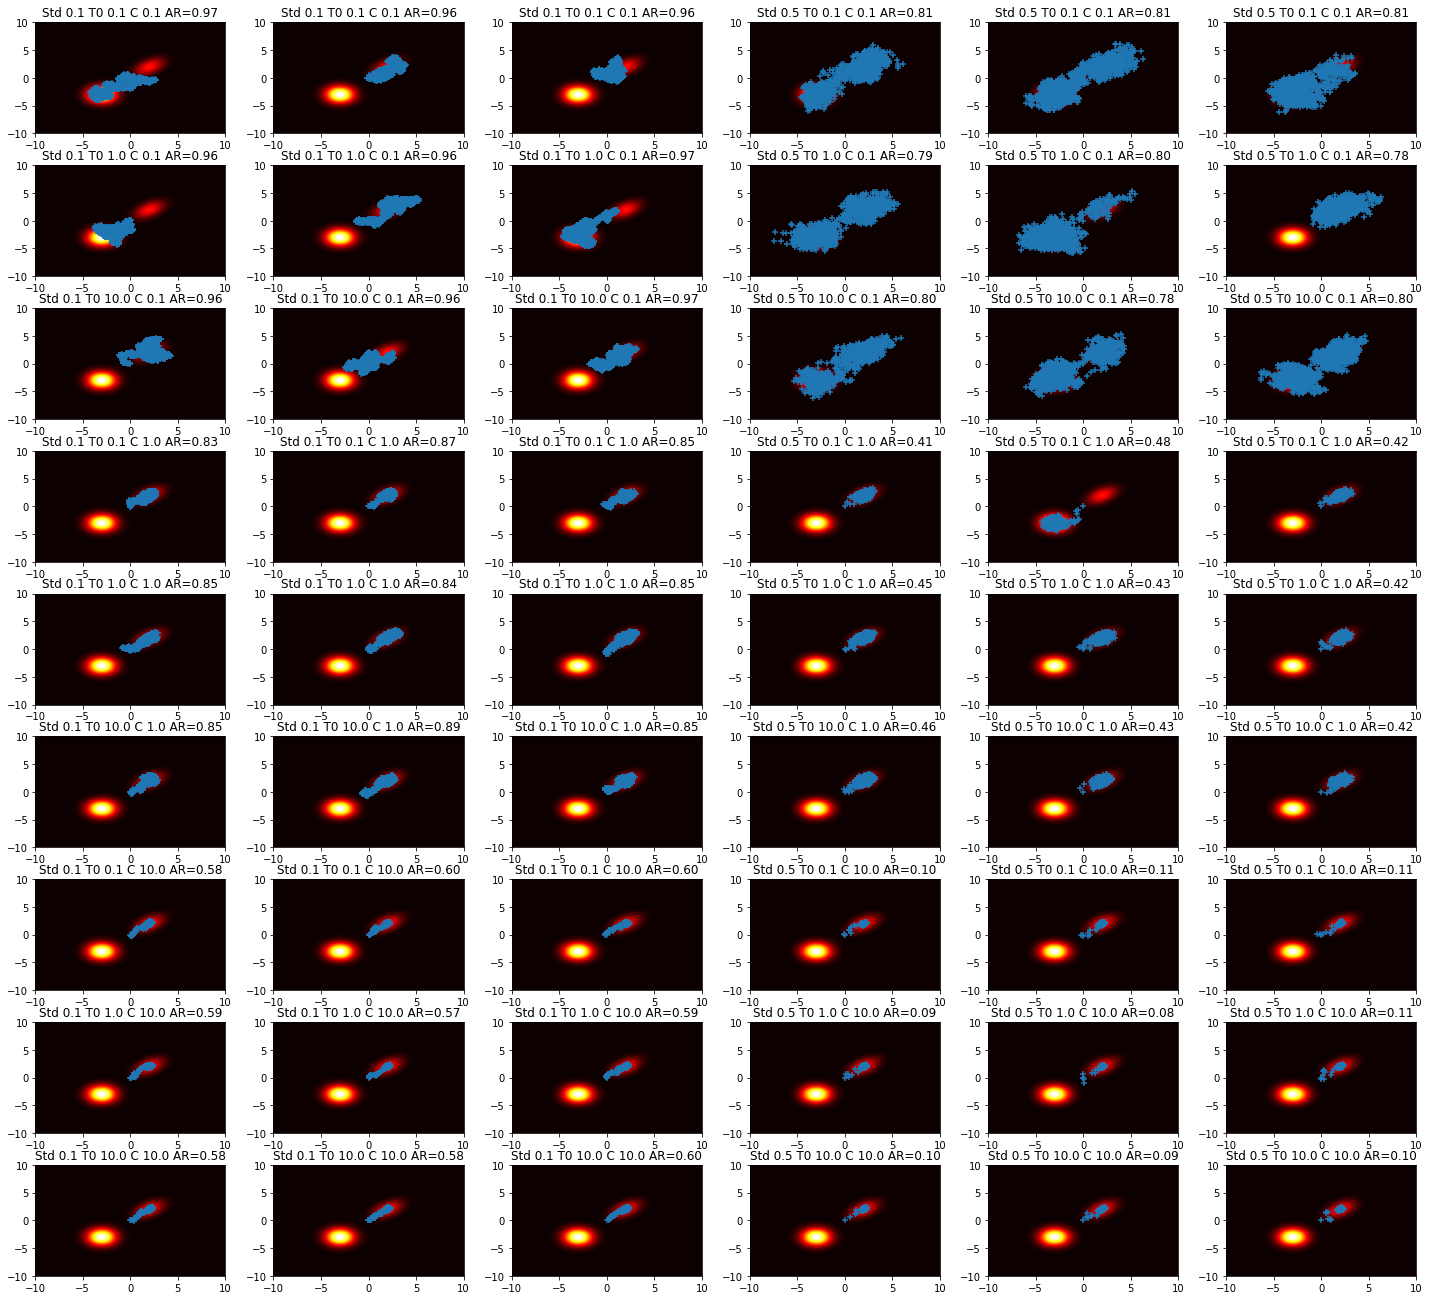

In [91]:
# PLEASE DO NOT REMOVE!
# Running the SA algorithm with different step sizes
num_epochs = 1500  # the number of epochs
stds_sa = [
    0.1,
    0.1,
    0.1,
    0.5,
    0.5,
    0.5,
]  # values of std; notice we repeat them due to randomness
T0s = [0.1, 1.0, 10.0]  # values of T0
Cs = [0.1, 1.0, 10.0]  # values of C

# plotting the convergence of the MH
fig_sa, axs = plt.subplots(len(Cs) * len(T0s), len(stds_sa), figsize=(20, 18))
fig_sa.tight_layout()

# Always start with the same point
x_init = np.asarray([[0.0, 0.0]])

# START SA
for i in range(len(Cs)):
    # Take a value for C
    C = Cs[i]
    for k in range(len(T0s)):
        # Take a value for the init temperature T0
        T0 = T0s[k]
        for j in range(len(stds_sa)):
            # take the std
            std = stds_sa[j]
            # init the SA
            sa = SimulatedAnnealing(x=x_init, prob=prob, std=std, T0=T0, C=C)
            # plot the sampling process
            plot_sampling_process(
                axs[len(T0s) * i + k, j],
                sampler=sa,
                title="Std " + str(sa.std) + " T0 " + str(T0) + " C " + str(C),
            )

**Question 8 (0-0.5pt)** How does the standard deviation influence the SA?

**Answer:** As we can somewhat see from the graphs, a higher standard deviation leads to more exploration of the space, while the lefthand smaller st dev shows a more 'hesitant' algorithm, that seems to stick to one spot. Of course the larger st dev also seems to have downsides of accepting more worse samples, but overall in this scenario it seems to be the one that models better.

**Question 9 (0-0.5pt)** How does the initial temperature, $T_0$, influence the SA?

**Answer:** The initial temperature affects the early acceptance of worse solutions. Higher temperature = higher acceptance and thus worse solutions but also leads to more exploration. Lower leads to lower and less exploration, and thus quicker convergence on local optima. This can be seen quite well in the second column, where the higher T0 leads the algorithm to crawl more towards the second mode and in the middle, which are worse solutions but come closer to the second mode as the T0 becomes higher.

**Question 10 (0-0.5pt)** How does the constant $C$ influence the SA?

**Answer:** In essence, C affects the temperature, the higher the faster the cooling and vice versa. In this case the higher C value can cause getting stuck in local optima while the lower one allows for more exploartion. Again, beautifully noticable in the first column, where the 10.0 C makes the values be very close together, little exploration, while the lowe 0.1 has more spread - more epxloration.

**Question 11 (0-0.5pt)** Which setting (i.e., std, $T_0$, $C$) did perform the best in terms of sampling?

**Answer:** Its always about balance, and it seems teh upper right corner is the most succesful in modeling the two peaks the best. Thus, the combination of High standad deviation and low C. As for temperature, it is a bit harder to see but it seems like the row with the highest T0 was the best at modeling, as the low T0 accepted many of the values in between the modes and one of the 1.0 runs didn't find the other mode. So, in this scenario and run, st dev of 0.5, C of 0.1 and T of 10.0 performed best from a purely visual evaluation.

**Question 12 (0-0.5pt)** How do different values of the hyperparameters (i.e., std, $T_0$, $C$) influence the acceptance ratio (AR)? Why?

**Answer:** There are many factors that influence the acceptance ratio. It seems that a higher st dev or T0 lead to higher AR, because both of these being high lead to more exploration and thus more likely to accept a worse solution. Lower has the opposite effect. C also has influence, a higher C leading to lower AR and vice versa. Again, cooling slower results in higher AR and thus more exploration, and otherwise faster cooling leads to lower AR and faster convergence but perhaps not on the optimal solution. This is all in keeping with the behaviours already described. It is an interplay and a balancing act.

## 4. Final remarks: MH vs. SA

Eventually, please answer the following last questions that will allow you to conclude the assignment and draw conclusions.

**Question 13 (0-0.5-1pt)**: Which of the two algorithms did perform better? Why?

**Answer**: Since we ran so many variants of especially SA, it is kind of unfair to draw such a conclusion. Some of the SA runs were very bad, while all of the MH ones were at least relatively acceptable. MH is much simpler and if the problem doesn't have too many local minima it is not a bad choice. If fine tuned well, it can reuslt in a rather good solution. However, the SA produced what seemed to be very well modeled solutions in few of the runs as mentioned in Q11. Overall, I do not feel comfortable drawing a conlusion as it would be biased in this case, but if I absolutely had to I'd say in this exercise we were able to play a bit more of the SA parameters and thus model a nice solution with it given paramters as given in Q11.

**Question 14 (0-0.5-1pt)**: Which of the two algorithms is easier to use? Why?

**Answer**: As mentioned, MH is easier becaure there are less veriables to consider and thus easier to implement, but they are quite similar in this implementation overall. It is also easiet to finetune because you dont have to balance 3+ variables, the standard deviation seems to do most of the work in MH, thus making ti easier to keep track of the way the different values of it shift the result of the algorithm. But then again, there may be a problem requiring the ability to fine tune more variables in which case the SA would be better, but from my experience MH is simpler and thus easier.